## Task 1 - Part 1

#### Step 1 − Import the necessary packages

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels import robust



#### Step 1.5 − Aux Functions

In [17]:
def regresssor_matrix (u, y, n, m, d):
    N = len(y) # samples number
    p = max(n, d+m) #initial conditions ?

    X=[]
    Y=[]

    for k in range (p, N):
        phi = []

        #past n values of y
        for i in range (1, n+1):
            phi.append(-y[k-i])

        #past m+1 values of u
        for i in range (0, m+1):
            phi.append(u[k-d-i])
        
        X.append(phi)
        Y.append(y[k])
    
    return np.array(X), np.array(Y)



#### Step 2 − Load the dataset

X_train shape: (2783, 2304)
Y_train shape: (2783,)
X_test shape: (696, 2304)
X_train_extra shape: (904, 2304)


TypeError: Invalid shape (2304,) for image data

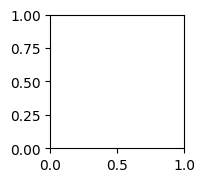

In [5]:
# Carregar os dados
X_test = np.load('Xtest1.npy')
X_train = np.load('Xtrain1.npy')
Y_train = np.load('Ytrain1.npy')
X_train_extra = np.load('Xtrain1_extra.npy')

# Verificar as dimensões dos datasets
print(f"X_train shape: {X_train.shape}")  # Exemplo: (n_imagens, 48, 48)
print(f"Y_train shape: {Y_train.shape}")  # Exemplo: (n_imagens,)
print(f"X_test shape: {X_test.shape}")    # Exemplo: (n_imagens, 48, 48)
print(f"X_train_extra shape: {X_train_extra.shape}")  # Exemplo: (n_imagens, 48, 48)

# Visualizar 5 primeiras imagens de treino com os rótulos
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')  # Assumindo imagens grayscale (usar 'gray')
    plt.axis('off')
    plt.title(f"Label: {Y_train[i]}")
plt.show()

# Visualizar 5 primeiras imagens de teste (sem rótulos)
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i], cmap='gray')  # Assumindo imagens grayscale
    plt.axis('off')
plt.show()

# Visualizar 5 primeiras imagens do dataset extra (sem rótulos)
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_extra[i], cmap='gray')  # Assumindo imagens grayscale
    plt.axis('off')
plt.show()


#### Step 3 − Plot the trainning features and outputs

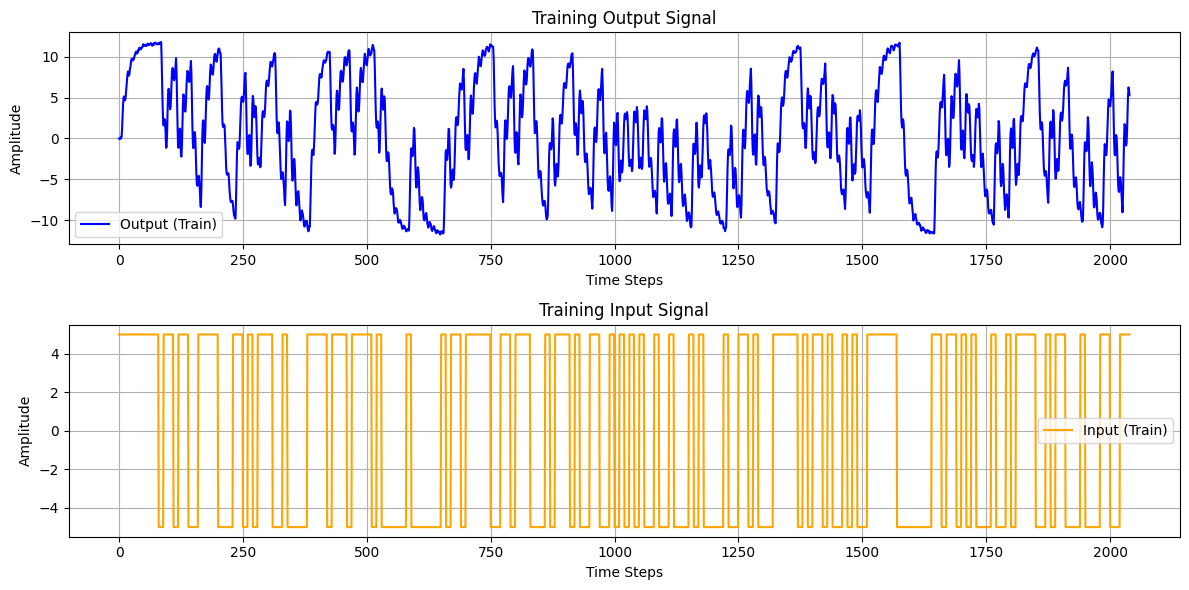

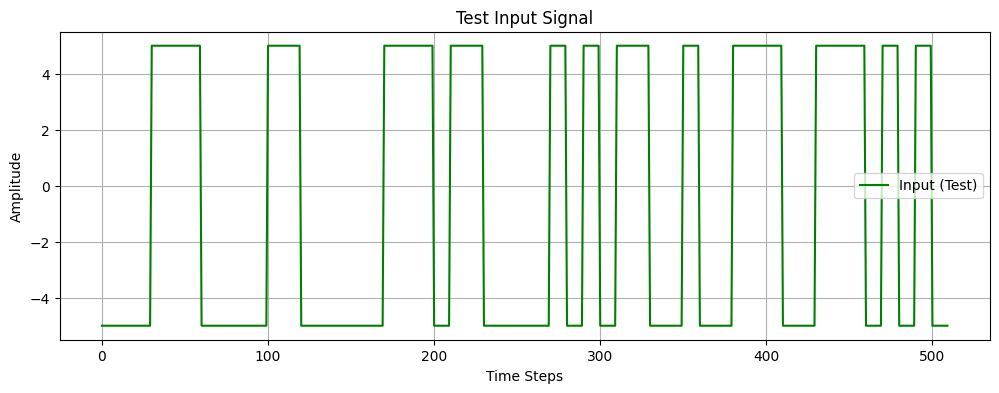

In [19]:
# Define time axes for training and testing sets
train_time = np.arange(len(output_train))  # Time index for training data
test_time = np.arange(len(u_test))         # Time index for test data

# Plotting the training input and output signals
plt.figure(figsize=(12, 6))

# Plot output_train (training set output)
plt.subplot(2, 1, 1)  # Two rows, one column, first plot
plt.plot(train_time, output_train, label="Output (Train)", color='blue')
plt.title("Training Output Signal")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

# Plot u_train (training set input)
plt.subplot(2, 1, 2)  # Two rows, one column, second plot
plt.plot(train_time, u_train, label="Input (Train)", color='orange')
plt.title("Training Input Signal")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

# Adjust the layout
plt.tight_layout()
plt.show()

# Plotting the test input signal (u_test)
plt.figure(figsize=(12, 4))
plt.plot(test_time, u_test, label="Input (Test)", color='green')
plt.title("Test Input Signal")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

plt.show()

####Step 3 - Scaling

In [20]:
# Initialize scalers for input and output
scaler_u = StandardScaler()
scaler_y = StandardScaler()

# Fit scaler on training data and transform both training and test data
u_train_scaled = scaler_u.fit_transform(u_train.reshape(-1, 1)).flatten()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

u_test_scaled = scaler_u.transform(u_test.reshape(-1, 1)).flatten()

# Check the mean and variance of scaled data
print(f'Scaled u_train mean: {u_train_scaled.mean()}, std: {u_train_scaled.std()}')
print(f'Scaled y_train mean: {y_train_scaled.mean()}, std: {y_train_scaled.std()}')

# Use the scaled data in your ARX modeling

Scaled u_train mean: -1.2538989454590003e-16, std: 0.9999999999999999
Scaled y_train mean: 4.179663151530001e-17, std: 1.0


#### Step 4.1 - Oulier removal - modified Z-scores 

Best parameters: n=20, m=20, d=5
Best SSE on training data: 0.5057691658106382


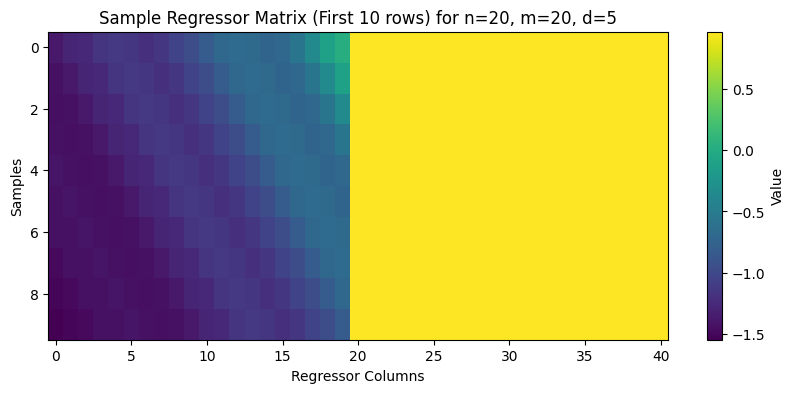

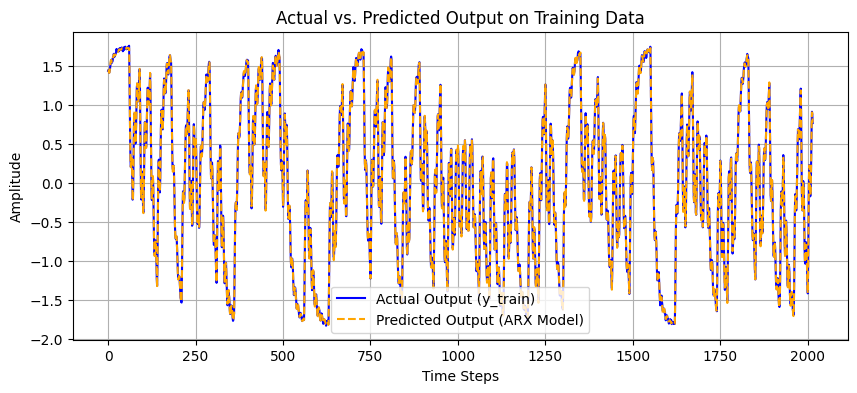

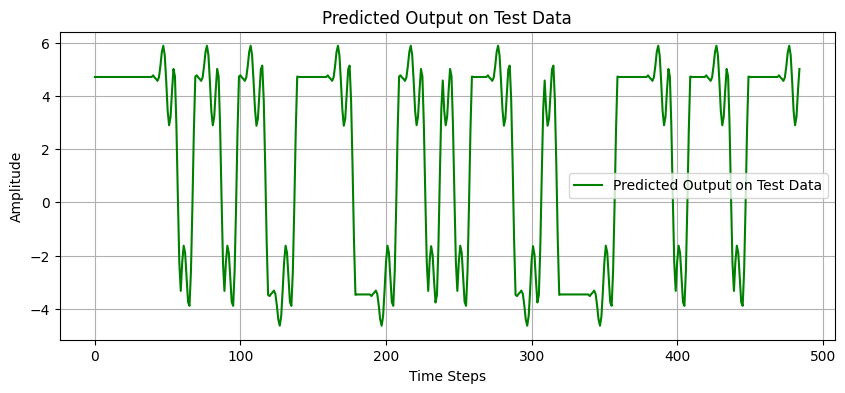

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define wider ranges for n, m, d
n_values = list(range(1, 21))  # now testing n from 1 to 20
m_values = list(range(1, 21))  # now testing m from 1 to 20
d_values = list(range(0, 6))    # now testing d from 0 to 5


# Scale the input and output data
scaler_u = StandardScaler()
scaler_y = StandardScaler()

# Fit the scalers on training data
u_train_scaled = scaler_u.fit_transform(u_train.reshape(-1, 1)).flatten()  # Reshape for scaler
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()  # Reshape for scaler

# Perform grid search to find the best n, m, d using training data
best_sse = np.inf
best_params = (None, None, None)

for n in n_values:
    for m in m_values:
        for d in d_values:
            # Create regressor matrix for training data
            X_train, Y_train = regresssor_matrix(u_train_scaled, y_train_scaled, n, m, d)
            
            # Estimate theta using least squares
            theta = np.linalg.lstsq(X_train, Y_train, rcond=None)[0]
            
            # Predict the output on the training data itself (validation)
            Y_pred_train = X_train @ theta
            
            # Calculate SSE (Sum of Squared Errors) on the training set
            sse = np.sum((Y_train - Y_pred_train) ** 2)
            
            # Update best parameters if current model is better
            if sse < best_sse:
                best_sse = sse
                best_params = (n, m, d)

print(f'Best parameters: n={best_params[0]}, m={best_params[1]}, d={best_params[2]}')
print(f'Best SSE on training data: {best_sse}')

# Plot sample regressor matrix (first 10 rows)
plt.figure(figsize=(10, 4))
plt.title(f"Sample Regressor Matrix (First 10 rows) for n={best_params[0]}, m={best_params[1]}, d={best_params[2]}")
plt.imshow(X_train[:10, :], cmap='viridis', aspect='auto')
plt.colorbar(label="Value")
plt.xlabel("Regressor Columns")
plt.ylabel("Samples")
plt.show()

# Plot actual vs predicted output on training data
plt.figure(figsize=(10, 4))
plt.plot(y_train_scaled[max(best_params[0], best_params[2] + best_params[1]):], label="Actual Output (y_train)", color='blue')
plt.plot(Y_pred_train, label="Predicted Output (ARX Model)", color='orange', linestyle='dashed')
plt.title("Actual vs. Predicted Output on Training Data")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# After determining the best n, m, d, predict on u_test
n_best, m_best, d_best = best_params

# Re-create the regressor matrix for the test input using scaled data
X_test = []
for k in range(max(n_best, d_best + m_best), len(u_test)):
    phi = []
    # Add past n_best values of y_train_scaled (since we don't have y_test)
    for i in range(1, n_best + 1):
        phi.append(-y_train_scaled[-i])  # Use the last known scaled y_train values for prediction
    # Add past m_best+1 values of u_test_scaled
    phi.extend(u_train_scaled[k - d_best:k - d_best + m_best + 1])  # Add scaled past values from u_train
    X_test.append(phi)

X_test = np.array(X_test)

# Scaling the test input using the scaler fitted on training regressor matrix
scaler_X = StandardScaler()
scaler_X.fit(X_train)  # Only fit the scaler on the training data regressor matrix
X_test_scaled = scaler_X.transform(X_test)

# Predict output for the test set
y_pred_test_scaled = X_test_scaled @ theta

# Inverse transform to get back to original scale
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

# Plot the predicted output for the test input
plt.figure(figsize=(10, 4))
plt.plot(y_pred_test, label="Predicted Output on Test Data", color='green')
plt.title("Predicted Output on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


#### Step 4 - With regularization


Best parameters: n=20, m=20, d=5
Best SSE on training data: 0.4831973065232297


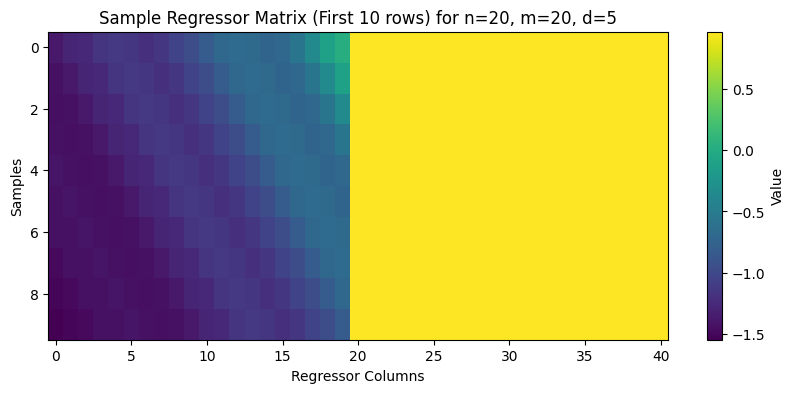

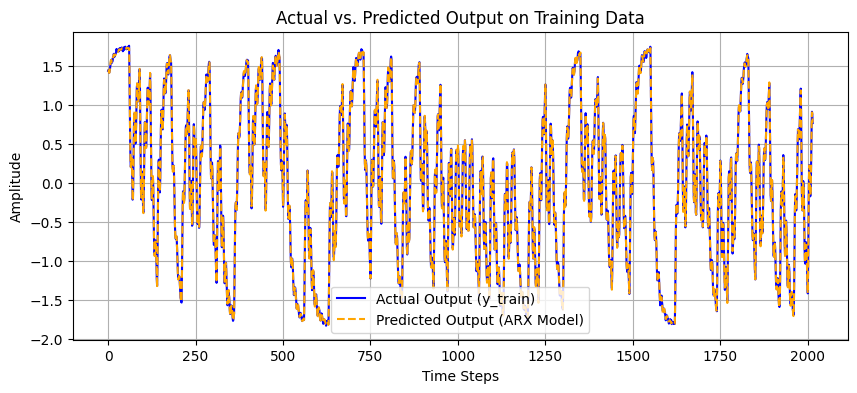

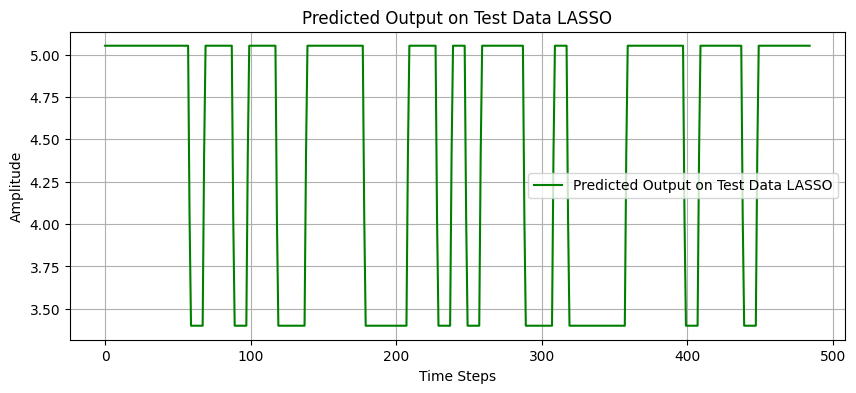

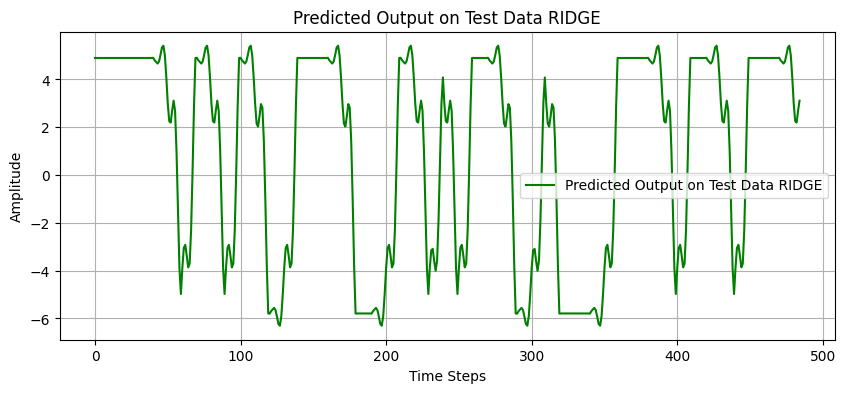

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define wider ranges for n, m, d
n_values = list(range(1, 21))  # now testing n from 1 to 20
m_values = list(range(1, 21))  # now testing m from 1 to 20
d_values = list(range(0, 6))    # now testing d from 0 to 5


# Scale the input and output data
scaler_u = StandardScaler()
scaler_y = StandardScaler()

# Fit the scalers on training data
u_train_scaled = scaler_u.fit_transform(u_train.reshape(-1, 1)).flatten()  # Reshape for scaler
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()  # Reshape for scaler

# Perform grid search to find the best n, m, d using training data
best_sse = np.inf
best_params = (None, None, None)

# Regularization parameters
alpha_lasso = 0.1  # Adjust this value as needed for Lasso
alpha_ridge = 1.0  # Adjust this value as needed for Ridge

for n in n_values:
    for m in m_values:
        for d in d_values:
            # Create regressor matrix for training data
            X_train, Y_train = regresssor_matrix(u_train_scaled, y_train_scaled, n, m, d)


            # Use Lasso regression
            lasso = Lasso(alpha=alpha_lasso)
            lasso.fit(X_train, Y_train)
            Y_pred_train_lasso = lasso.predict(X_train)
            sse_lasso = np.sum((Y_train - Y_pred_train_lasso) ** 2)

            # Use Ridge regression
            ridge = Ridge(alpha=alpha_ridge)
            ridge.fit(X_train, Y_train)
            Y_pred_train_ridge = ridge.predict(X_train)
            sse_ridge = np.sum((Y_train - Y_pred_train_ridge) ** 2)
            
          # Update best parameters if current model is better
            if sse_lasso < best_sse:
                best_sse = sse_lasso
                best_params = (n, m, d, 'Lasso', alpha_lasso)

            if sse_ridge < best_sse:
                best_sse = sse_ridge
                best_params = (n, m, d, 'Ridge', alpha_ridge)

print(f'Best parameters: n={best_params[0]}, m={best_params[1]}, d={best_params[2]}')
print(f'Best SSE on training data: {best_sse}')

# Plot sample regressor matrix (first 10 rows)
plt.figure(figsize=(10, 4))
plt.title(f"Sample Regressor Matrix (First 10 rows) for n={best_params[0]}, m={best_params[1]}, d={best_params[2]}")
plt.imshow(X_train[:10, :], cmap='viridis', aspect='auto')
plt.colorbar(label="Value")
plt.xlabel("Regressor Columns")
plt.ylabel("Samples")
plt.show()

# Plot actual vs predicted output on training data
plt.figure(figsize=(10, 4))
plt.plot(y_train_scaled[max(best_params[0], best_params[2] + best_params[1]):], label="Actual Output (y_train)", color='blue')
plt.plot(Y_pred_train, label="Predicted Output (ARX Model)", color='orange', linestyle='dashed')
plt.title("Actual vs. Predicted Output on Training Data")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# After determining the best n, m, d, predict on u_test
n_best, m_best, d_best, reg_type, alpha_best = best_params  # Adjusted unpacking

# Re-create the regressor matrix for the test input using scaled data
X_test = []
for k in range(max(n_best, d_best + m_best), len(u_test)):
    phi = []
    # Add past n_best values of y_train_scaled (since we don't have y_test)
    for i in range(1, n_best + 1):
        phi.append(-y_train_scaled[-i])  # Use the last known scaled y_train values for prediction
    # Add past m_best+1 values of u_test_scaled
    phi.extend(u_train_scaled[k - d_best:k - d_best + m_best + 1])  # Add scaled past values from u_train
    X_test.append(phi)

X_test = np.array(X_test)

# Scaling the test input using the scaler fitted on training regressor matrix
scaler_X = StandardScaler()
scaler_X.fit(X_train)  # Only fit the scaler on the training data regressor matrix
X_test_scaled = scaler_X.transform(X_test)

# Predict output for the test set using the best model found

y_pred_test_scaled_lasso = lasso.predict(X_test_scaled)

y_pred_test_scaled_ridge = ridge.predict(X_test_scaled)

# Inverse transform to get back to original scale
y_pred_test_lasso = scaler_y.inverse_transform(y_pred_test_scaled_lasso.reshape(-1, 1)).flatten()

# Inverse transform to get back to original scale
y_pred_test_ridge = scaler_y.inverse_transform(y_pred_test_scaled_ridge.reshape(-1, 1)).flatten()

# Plot the predicted output for the test input
plt.figure(figsize=(10, 4))
plt.plot(y_pred_test_lasso, label="Predicted Output on Test Data LASSO", color='green')
plt.title("Predicted Output on Test Data LASSO")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# Plot the predicted output for the test input
plt.figure(figsize=(10, 4))
plt.plot(y_pred_test_ridge, label="Predicted Output on Test Data RIDGE", color='green')
plt.title("Predicted Output on Test Data RIDGE")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


#### Step 4 - Trying hyperparameter tuning - Random search


Training Lasso for n=19, m=18, d=4...


/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.288e-01, tolerance: 1.169e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e-01, tolerance: 1.169e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali


Training Lasso for n=19, m=18, d=5...


/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.272e-01, tolerance: 1.167e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-01, tolerance: 2.026e-01
  model = cd_fast.enet_coordinate_descent(



Training Lasso for n=19, m=19, d=4...


/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e-01, tolerance: 1.167e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e-01, tolerance: 1.167e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali


Training Lasso for n=19, m=19, d=5...


/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.264e-01, tolerance: 1.167e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e-01, tolerance: 1.167e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali


Training Lasso for n=20, m=18, d=4...


/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.294e-01, tolerance: 1.169e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e-01, tolerance: 1.169e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali


Training Lasso for n=20, m=18, d=5...

Training Lasso for n=20, m=19, d=4...


/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.274e-01, tolerance: 1.167e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.387e-01, tolerance: 1.167e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali


Training Lasso for n=20, m=19, d=5...


/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.386e-01, tolerance: 1.167e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.476e-01, tolerance: 1.469e-01
  model = cd_fast.enet_coordinate_descent(
/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Best parameters: {'n': 20, 'm': 19, 'd': 5, 'alpha': 0.07196856730011514}
Best cross-validated MSE on training data: 0.00024496530032081367
Best regularization algorithm: Ridge(alpha=0.07196856730011514, max_iter=50000)


/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e-01, tolerance: 2.024e-01
  model = cd_fast.enet_coordinate_descent(


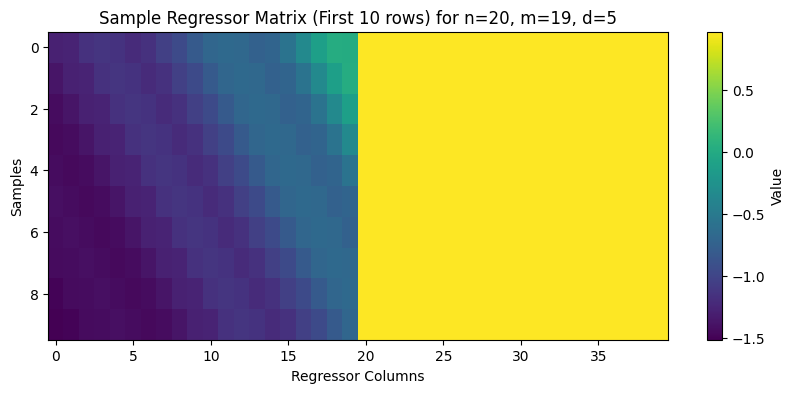

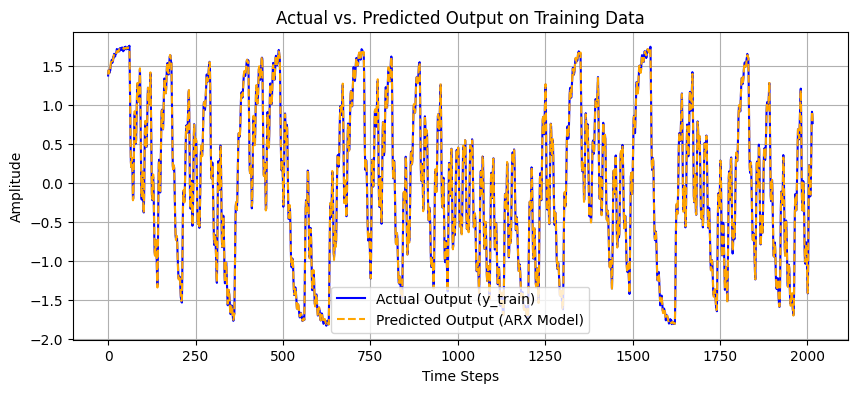

Shape of X_test: (486, 40)
Shape of X_train: (2016, 40)


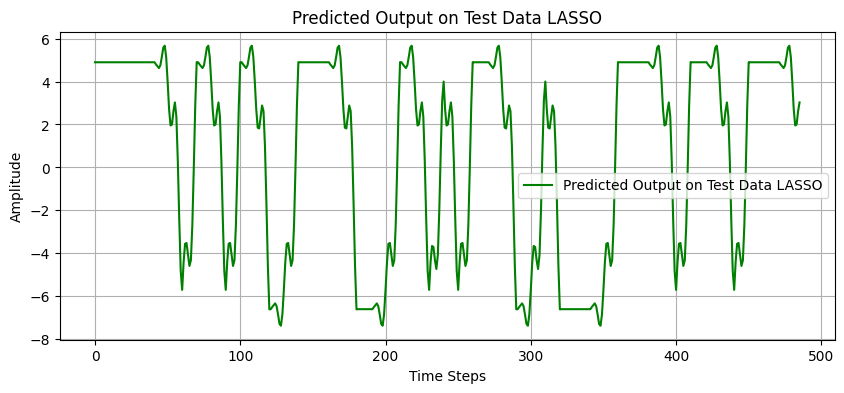

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge

# Define wider ranges for n, m, d
n_values = list(range(0, 10))  # now testing n from 1 to 20
m_values = list(range(0, 10))  # now testing m from 1 to 20
d_values = list(range(0, 10))    # now testing d from 0 to 5

# Scale the input and output data
scaler_u = StandardScaler()
scaler_y = StandardScaler()

# Fit the scalers on training data
u_train_scaled = scaler_u.fit_transform(u_train.reshape(-1, 1)).flatten()  # Reshape for scaler
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()  # Reshape for scaler

# Prepare to collect the best model
best_model = None
best_score = np.inf
best_params = {}
best_algorithm = None 

# Hyperparameter grid
param_distributions = {
    'alpha': np.logspace(-6, 1, 50),  # Regularization strength for Lasso and Ridge
}

def random_search_lasso_ridge(u_train_scaled, y_train_scaled):
    global best_model, best_score, best_params
    
    for n in n_values:
        for m in m_values:
            for d in d_values:
                # Create regressor matrix for training data
                X_train, Y_train = regresssor_matrix(u_train_scaled, y_train_scaled, n, m, d)

                print(f"\nTraining Lasso for n={n}, m={m}, d={d}...")

                # Set up randomized search for Lasso with increased iterations
                lasso = Lasso(max_iter=50000)  # Increase max_iter for convergence
                lasso_search = RandomizedSearchCV(lasso, param_distributions={'alpha': param_distributions['alpha']},
                                                   scoring='neg_mean_squared_error', n_iter=20, cv=3)
                lasso_search.fit(X_train, Y_train)
                
                # Evaluate and save the best Lasso model
                if -lasso_search.best_score_ < best_score:
                    best_score = -lasso_search.best_score_
                    best_params = {'n': n, 'm': m, 'd': d, 'alpha': lasso_search.best_params_['alpha']}
                    best_model = lasso_search.best_estimator_
                    best_algorithm = 'Lasso'  # Track the best algorithm
                
                # Set up randomized search for Ridge with increased iterations
                ridge = Ridge(max_iter=50000)  # Increase max_iter for convergence
                ridge_search = RandomizedSearchCV(ridge, param_distributions={'alpha': param_distributions['alpha']},
                                                   scoring='neg_mean_squared_error', n_iter=20  , cv=3)
                ridge_search.fit(X_train, Y_train)
                
                # Evaluate and save the best Ridge model
                if -ridge_search.best_score_ < best_score:
                    best_score = -ridge_search.best_score_
                    best_params = {'n': n, 'm': m, 'd': d, 'alpha': ridge_search.best_params_['alpha']}
                    best_model = ridge_search.best_estimator_
                    best_algorithm = 'Ridge'  # Track the best algorithm

# Run the random search
random_search_lasso_ridge(u_train_scaled, y_train_scaled)

print(f'Best parameters: {best_params}')
print(f'Best cross-validated MSE on training data: {best_score}')
print(f'Best regularization algorithm: {best_model}')  # Print the best algorithm

# Prepare regressor matrix for the best params
X_train, Y_train = regresssor_matrix(u_train_scaled, y_train_scaled, best_params['n'], best_params['m'], best_params['d'])

# Plot sample regressor matrix (first 10 rows)
plt.figure(figsize=(10, 4))
plt.title(f"Sample Regressor Matrix (First 10 rows) for n={best_params['n']}, m={best_params['m']}, d={best_params['d']}")
plt.imshow(X_train[:10, :], cmap='viridis', aspect='auto')
plt.colorbar(label="Value")
plt.xlabel("Regressor Columns")
plt.ylabel("Samples")
plt.show()

# Plot actual vs predicted output on training data
Y_pred_train = best_model.predict(X_train)
plt.figure(figsize=(10, 4))
plt.plot(y_train_scaled[max(best_params['n'], best_params['m'] + best_params['d']):], label="Actual Output (y_train)", color='blue')
plt.plot(Y_pred_train, label="Predicted Output (ARX Model)", color='orange', linestyle='dashed')
plt.title("Actual vs. Predicted Output on Training Data")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

# After determining the best parameters, predict on u_test
n_best, m_best, d_best, alpha_best = best_params['n'], best_params['m'], best_params['d'], best_params['alpha']

# Re-create the regressor matrix for the test input using scaled data
X_test = []
for k in range(max(n_best, d_best + m_best), len(u_test)):
    phi = []
    # Add past n_best values of y_train_scaled (since we don't have y_test)
    for i in range(1, n_best + 1):
        phi.append(-y_train_scaled[-i])  # Use the last known scaled y_train values for prediction
    # Add past m_best+1 values of u_test_scaled
    phi.extend(u_train_scaled[k - d_best:k - d_best + m_best + 1])  # Add scaled past values from u_train
    X_test.append(phi)

X_test = np.array(X_test)

# Check the shape of the test matrix
print("Shape of X_test:", X_test.shape)
print("Shape of X_train:", X_train.shape)

# Scaling the test input using the scaler fitted on training regressor matrix
scaler_X = StandardScaler()
scaler_X.fit(X_train)  # Only fit the scaler on the training data regressor matrix
X_test_scaled = scaler_X.transform(X_test)

# Predict output for the test set using the best model found
y_pred_test_scaled = best_model.predict(X_test_scaled)

# Inverse transform to get back to original scale
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

# Plot the predicted output for the test input
plt.figure(figsize=(10, 4))
plt.plot(y_pred_test, label="Predicted Output on Test Data LASSO", color='green')
plt.title("Predicted Output on Test Data LASSO")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


#### Step 5 − Scaling


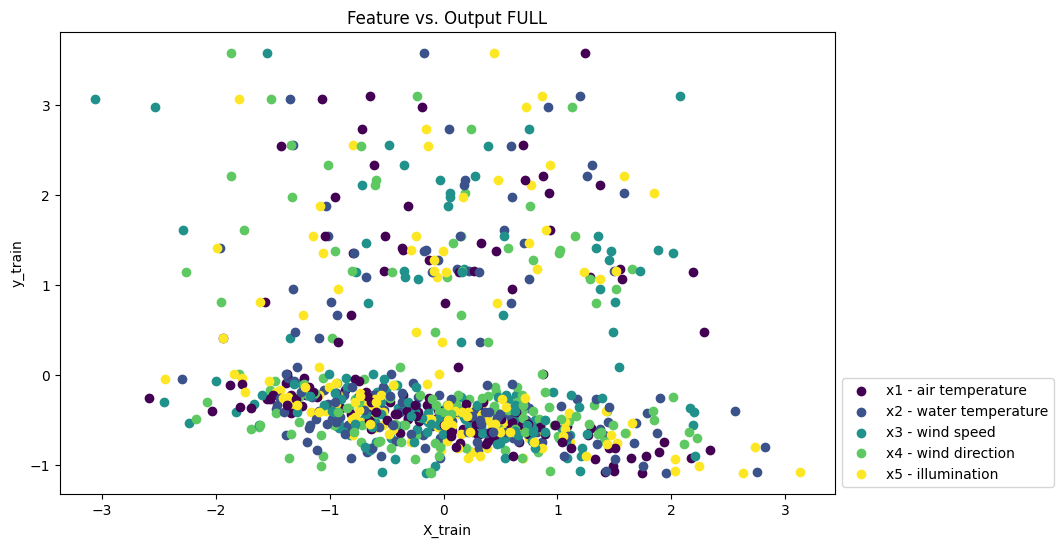

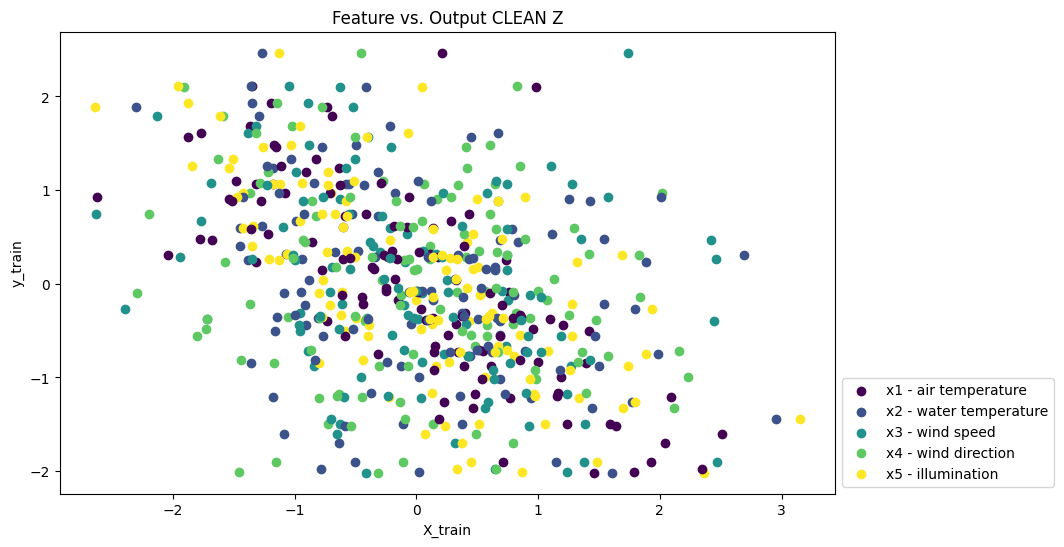

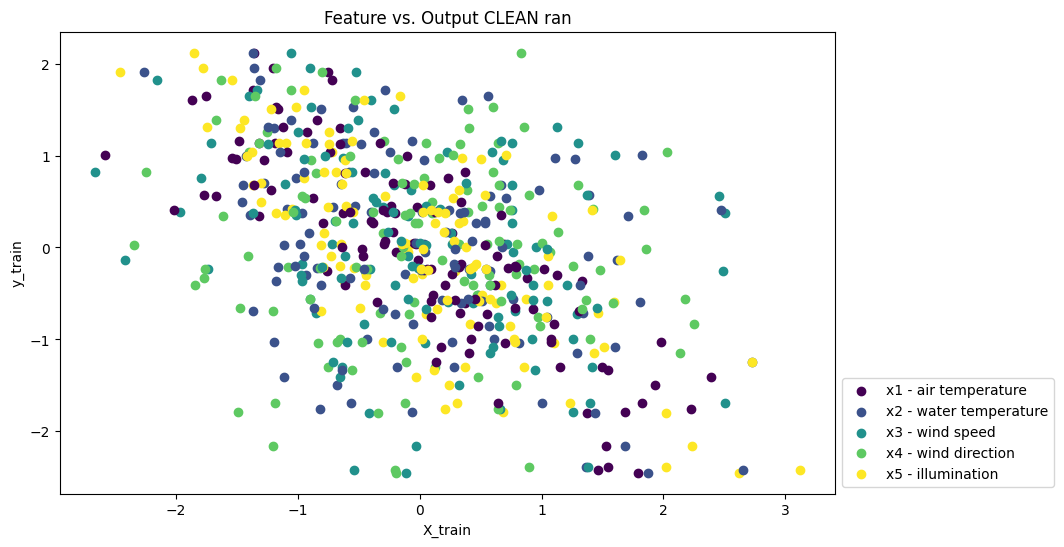

In [18]:

#for correct scaling
y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1,1)

#Scaling all of the data
scaler_X = StandardScaler()
X_val_scaled = scaler_X.fit_transform(X_val)  
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.fit_transform(y_val)

num_colors = 5 # nr_colors = nr_features
gradient = np.linspace(0, 1, num_colors)
colormap = plt.colormaps['viridis']
colors = colormap(gradient)

plt.figure(figsize=(10,6))
plt.title('Feature vs. Output FULL')
plt.xlabel('X_train')
plt.ylabel('y_train')


#plotting scaled data
for s,sample in enumerate(X_train_scaled):
    for f, feature in enumerate(sample):
        plt.scatter(feature, y_train_scaled[s], color= colors[f])

plt.legend(labels, loc='lower left', bbox_to_anchor=(1,0))
plt.show()


#same scaling, for after outlier removal
y_train_clean = np.array(y_train_clean_z).reshape(-1, 1)
y_val_clean = np.array(y_val_clean_z).reshape(-1, 1)


X_val_scaled_clean = scaler_X.fit_transform(X_val_clean_z)  
X_train_clean_scaled = scaler_X.fit_transform(X_train_clean_z)
X_test_scaled = scaler_X.transform(X_test)

y_train_clean_scaled = scaler_y.fit_transform(y_train_clean)
y_val_scaled = scaler_y.fit_transform(y_val_clean)

num_colors = 5 # nr_colors = nr_features
gradient = np.linspace(0, 1, num_colors)
colormap = plt.colormaps['viridis']
colors = colormap(gradient)

plt.figure(figsize=(10,6))
plt.title('Feature vs. Output CLEAN Z')
plt.xlabel('X_train')
plt.ylabel('y_train')


#scaled outlier removal
for s,sample in enumerate(X_train_clean_scaled):
    for f, feature in enumerate(sample):
        plt.scatter(feature, y_train_clean_scaled[s], color= colors[f])

plt.legend(labels, loc='lower left', bbox_to_anchor=(1,0))
plt.show()

y_train_clean = np.array(y_train_clean_ran).reshape(-1, 1)
y_val_clean = np.array(y_val_clean_z).reshape(-1, 1)


X_val_scaled_clean_ran = scaler_X.fit_transform(X_val_clean_ran)  
X_train_clean_scaled_ran = scaler_X.fit_transform(X_train_clean_ran)
X_test_scaled = scaler_X.transform(X_test)

y_train_clean_scaled_ran = scaler_y.fit_transform(y_train_clean)
y_val_scaled_ran = scaler_y.fit_transform(y_val_clean)


plt.figure(figsize=(10,6))
plt.title('Feature vs. Output CLEAN ran')
plt.xlabel('X_train')
plt.ylabel('y_train')


#scaled outlier removal
for s,sample in enumerate(X_train_clean_scaled_ran):
    for f, feature in enumerate(sample):
        plt.scatter(feature, y_train_clean_scaled_ran[s], color= colors[f])

plt.legend(labels, loc='lower left', bbox_to_anchor=(1,0))
plt.show()

#### Step 6 − Linear Regression 


In [19]:
# models:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
y_pred_scaled = model.predict(X_val_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse_linear_full = mean_squared_error(y_val, y_pred)
print(f"Ridge MSE - Full data: {mse_linear_full}")


# models:
model_clean = LinearRegression()
model_clean.fit(X_train_clean_scaled, y_train_clean_scaled)
y_pred_scaled = model_clean.predict(X_val_scaled_clean)

y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse_linear = mean_squared_error(y_val_clean, y_pred)
print(f"Ridge MSE - Z outlier: {mse_linear}")


model_ran = LinearRegression()
model_ran.fit(X_train_clean_scaled_ran, y_train_clean_scaled_ran)
y_pred_scaled = model_ran.predict(X_val_scaled_clean_ran)

y_pred = scaler_y.inverse_transform(y_pred_scaled)

mse_linear_ran = mean_squared_error(y_val_clean_ran, y_pred)
print(f"Ridge MSE - RANSAC outlier: {mse_linear_ran}")





Ridge MSE - Full data: 19.80847601521443
Ridge MSE - Z outlier: 0.06298610858414072
Ridge MSE - RANSAC outlier: 0.11063624258114693


#### Step 6 − Regularization with Mod z outlier


In [20]:
from sklearn.linear_model import ElasticNet

# models:
#ridge = Ridge(alpha=0.1)

ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100]}
ridge_cv = GridSearchCV(Ridge(), ridge_params, cv=10, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_clean_scaled, y_train_clean_scaled)

#Lasso = Lasso(alpha=1)


y_pred_ridge_scaled= ridge_cv.predict(X_val_scaled_clean)
#print(y_pred_ridge_scaled)

y_pred_ridge = scaler_y.inverse_transform(y_pred_ridge_scaled)

mse_ridge = mean_squared_error(y_val_clean_z, y_pred_ridge)
print(f"Ridge MSE: {mse_ridge}  Best Ridge alpha: {ridge_cv.best_params_}")



# For Lasso
lasso_params = {'alpha': [ 0.001, 0.01, 0.1, 1.0, 10, 100]}
lasso_cv = GridSearchCV(Lasso(), lasso_params, cv=10, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_clean_scaled, y_train_clean_scaled)

y_pred_lasso_scaled= lasso_cv.predict(X_val_scaled_clean)
y_pred_lasso_scaled = y_pred_lasso_scaled.reshape(-1, 1)

y_pred_lasso = scaler_y.inverse_transform(y_pred_lasso_scaled)

# Calculate MSE for Lasso
mse_lasso = mean_squared_error(y_val_clean_z, y_pred_lasso)
print(f"Lasso MSE: {mse_lasso}  Best Lasso alpha: {lasso_cv.best_params_}")


# Define parameter grid for ElasticNet
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Create GridSearchCV object
elastic_cv = GridSearchCV(ElasticNet(), elastic_params, cv=10, scoring='neg_mean_squared_error')

# Fit the model
elastic_cv.fit(X_train_clean_scaled, y_train_clean_scaled)


# Predict using the validation set with the best model
y_pred_elastic_scaled = elastic_cv.predict(X_val_scaled_clean)

# Inverse transform the predictions if necessary (assuming you're scaling the targets)
# y_pred_elastic = scaler.inverse_transform(y_pred_elastic_scaled.reshape(-1, 1))

# Calculate MSE
mse_elastic = mean_squared_error(y_val_clean_z, y_pred_elastic_scaled)

# Print MSE
print(f"ElasticNet MSE: {mse_elastic}  Best ElasticNet params: {elastic_cv.best_params_}")

print(f"Linear MSE: {mse_linear}")









Ridge MSE: 0.052941593524517855  Best Ridge alpha: {'alpha': 0.1}
Lasso MSE: 0.05101829746816915  Best Lasso alpha: {'alpha': 0.001}
ElasticNet MSE: 0.21822746478916843  Best ElasticNet params: {'alpha': 0.001, 'l1_ratio': 0.9}
Linear MSE: 0.06298610858414072


/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-02, tolerance: 1.102e-02
  model = cd_fast.enet_coordinate_descent(


#### Step 6 − Regularization with RANSAC outlier

In [21]:
from sklearn.linear_model import ElasticNet

# models:
#ridge = Ridge(alpha=0.1)

ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100]}
ridge_cv = GridSearchCV(Ridge(), ridge_params, cv=10, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_clean_scaled_ran, y_train_clean_scaled_ran)

#Lasso = Lasso(alpha=1)


y_pred_ridge_scaled_ran= ridge_cv.predict(X_val_scaled_clean_ran)
#print(y_pred_ridge_scaled)

y_pred_ridge_ran = scaler_y.inverse_transform(y_pred_ridge_scaled_ran)

mse_ridge = mean_squared_error(y_val_clean_ran, y_pred_ridge_ran)
print(f"Ridge MSE: {mse_ridge}  Best Ridge alpha: {ridge_cv.best_params_}")



# For Lasso
lasso_params = {'alpha': [ 0.001, 0.01, 0.1, 1.0, 10, 100]}
lasso_cv = GridSearchCV(Lasso(), lasso_params, cv=10, scoring='neg_mean_squared_error')
lasso_cv.fit(X_train_clean_scaled_ran, y_train_clean_scaled_ran)

y_pred_lasso_scaled_ran= lasso_cv.predict(X_val_scaled_clean_ran)
y_pred_lasso_scaled_ran = y_pred_lasso_scaled_ran.reshape(-1, 1)

y_pred_lasso_ran = scaler_y.inverse_transform(y_pred_lasso_scaled_ran)

# Calculate MSE for Lasso
mse_lasso = mean_squared_error(y_val_clean_ran, y_pred_lasso_ran)
print(f"Lasso MSE: {mse_lasso}  Best Lasso alpha: {lasso_cv.best_params_}")


# Define parameter grid for ElasticNet
elastic_params = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Create GridSearchCV object
elastic_cv = GridSearchCV(ElasticNet(), elastic_params, cv=10, scoring='neg_mean_squared_error')

# Fit the model
elastic_cv.fit(X_train_clean_scaled_ran, y_train_clean_scaled_ran)


# Predict using the validation set with the best model
y_pred_elastic_scaled_ran = elastic_cv.predict(X_val_scaled_clean_ran)

# Inverse transform the predictions if necessary (assuming you're scaling the targets)
# y_pred_elastic = scaler.inverse_transform(y_pred_elastic_scaled.reshape(-1, 1))

# Calculate MSE
mse_elastic = mean_squared_error(y_val_clean_ran, y_pred_elastic_scaled_ran)

# Print MSE
print(f"ElasticNet MSE: {mse_elastic}  Best ElasticNet params: {elastic_cv.best_params_}")

print(f"Linear MSE: {mse_linear}")









Ridge MSE: 0.11071048029951944  Best Ridge alpha: {'alpha': 0.001}
Lasso MSE: 0.11501881220232453  Best Lasso alpha: {'alpha': 0.001}
ElasticNet MSE: 0.5370288600350483  Best ElasticNet params: {'alpha': 0.001, 'l1_ratio': 0.9}
Linear MSE: 0.06298610858414072


/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.577e-01, tolerance: 1.600e-02
  model = cd_fast.enet_coordinate_descent(


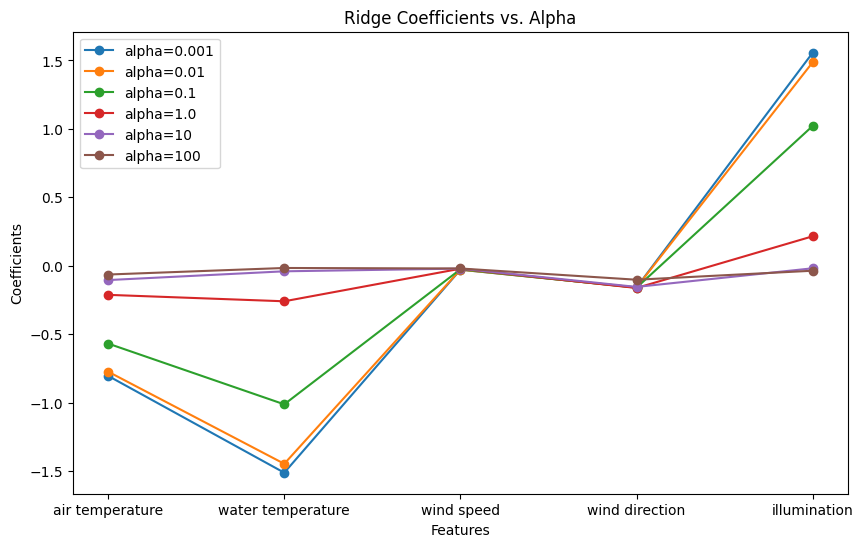

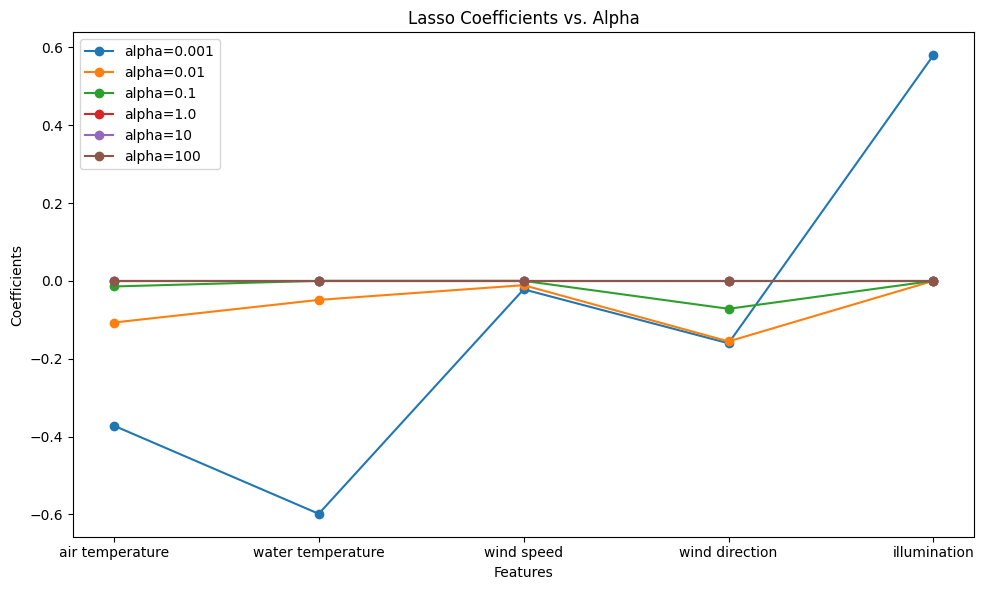

In [22]:
# Example data: replace with actual feature names
feature_names = ['air temperature', 'water temperature', 'wind speed', 'wind direction', 'illumination']
alphas = [0.001, 0.01, 0.1, 1.0, 10, 100]

# Initialize lists to store coefficients
coeffs_ridge = []
coeffs_lasso = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train_scaled)
    coeffs_ridge.append(ridge.coef_.flatten())

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_scaled, y_train_scaled)
    coeffs_lasso.append(lasso.coef_)

# Convert to numpy arrays for easier plotting
coeffs_ridge = np.array(coeffs_ridge)
coeffs_lasso = np.array(coeffs_lasso)


plt.figure(figsize=(10, 6))

# Plot Ridge coefficients

for i, alpha in enumerate(alphas):
    plt.plot(feature_names, coeffs_ridge[i], marker='o', label=f'alpha={alpha}')
plt.title('Ridge Coefficients vs. Alpha')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.legend()



plt.figure(figsize=(10, 6))
# Plot Lasso coefficients

for i, alpha in enumerate(alphas):
    plt.plot(feature_names, coeffs_lasso[i], marker='o', label=f'alpha={alpha}')
plt.title('Lasso Coefficients vs. Alpha')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.legend()


plt.tight_layout()
plt.show()

#### Step 6 − Train the best model using the fit() method

In [27]:
# create the best model (with alpha = best alpha):
best_Lasso = Lasso(lasso_cv.best_params_['alpha'])
# train the best model with the trainning data:
best_Lasso.fit(X_train_scaled, y_train_scaled)

/home/olivas/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.577e-01, tolerance: 1.600e-02
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.001)

#### Step 7 − Predict the output for the testing data

In [28]:

y_pred_lasso_scaled= best_Lasso.predict(X_test_scaled)

y_pred_lasso_scaled = y_pred_lasso_scaled.reshape(-1, 1)
#print(y_pred_ridge_scaled)

y_pred_lasso = scaler_y.inverse_transform(y_pred_lasso_scaled)
print(y_pred_lasso.shape)

(200, 1)


In [25]:
# save ypred_test as .txt file:
np.save('ytest_pred', y_pred_lasso)